<CENTER>
</br>
<p><font size="5">  M2MO - Machine Learning in Finance </font></p>
<p><font size="5">  Project - The Deep Parametric PDE Method </font></p>
<p><font size="4">  MICHAL Tanguy & PÉCHEUL Ronan & SANGLIER Nathan </font></p>
<p><font size="3"></br>April 2025</font></br></div>
<p><span style="color:blue">student1@email.com, ronan.pecheul@ensae.fr, nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

This notebook contains a simple implementation of the Deep Parametric PDE method for the case study of pricing a basket put option in the multivariate Black-Scholes model, as described in the report. Our code is inspired by the [Github repository](https://colab.research.google.com/github/LWunderlich/DeepPDE/blob/main/TwoAssetsExample/DeepParametricPDEExample.ipynb) associated to the paper "<i>The deep parametric PDE method and applications to option pricing</i>" of K. Glau and L. Wunderlich.

In [221]:
import  urllib
import  os

import  numpy                       as      np
import  matplotlib.pyplot           as      plt
import  tensorflow                  as      tf
import  tensorflow.keras.backend    as      K

from    tensorflow                  import  keras
from    scipy.stats                 import  norm
from    numpy.polynomial.hermite    import  hermgauss

np.random.seed(42)

In [222]:
nr_samples_surface_plot         = 21 # nb points in each direction for the surface plot (varying asset prices)
nr_samples_scatter_plot         = 1000 # nb random points for the scatter plot (varying time, asset prices, option params)
nr_samples_error_calculation    = 10000 # nb random points for approx L2 and Linf errors

In [223]:
# Model parameters. Re-train model after any changes.
s_min_interest, s_max_interest = 25, 150
t_min_interest, t_max_interest = 0.5, 4.

riskfree_rate_min, riskfree_rate_max, riskfree_rate_eval            = 0.1, 0.3, 0.2
volatility_min, volatility_max, volatility1_eval, volatility2_eval  = 0.1, 0.3, 0.1, 0.3
correlation_min, correlation_max, correlation_eval                  = 0.2, 0.8, 0.5

strike_price = 100.

In [224]:
# NN parameters. Re-train model after any changes.
nr_nodes_per_layer      = 90
initial_learning_rate   = 0.001
localisation_parameter  = 1/10.

n_train     = 10000
nr_epochs   = 601

## Internal parameters
These variables should not be changes, unless you are planing to adapt the code to new situations.

In [225]:
dimension_state     = 2 # nb of assets
dimension_parameter = 4 # nb of params (risk-free rate, volatilities, correlation) = 2 * dimension_state
dimension_total     = 1 + dimension_state + dimension_parameter # nb of dimensions in the input space (time, asset prices, params)

t_min, t_max    = 0., t_max_interest
s_max           = strike_price * (1 + 3*volatility_max*t_max)
x_max           = np.log(s_max)
x_min           = 2*np.log(strike_price) - x_max

normalised_max = 1
normalised_min = -1

def transform_ab_to_cd(x, a, b, c, d):
    """
    Perform a linear transformation of a scalar from the source interval
    to the target interval.

    Keyword arguments:
    x -- scalar point(s) to transform
    a, b -- interval to transform from
    c, d -- interval to transform to
    """
    return c + (x-a) * (d-c) / (b-a)

def transform_to_logprice(x):
    """ Transform normalised variable to the log-price. """
    return transform_ab_to_cd(x, normalised_min, normalised_max, x_min, x_max)

def transform_to_time(t):
    """ Transform normalised variable to the time variable. """
    return transform_ab_to_cd(t, normalised_min, normalised_max, t_min, t_max)

def normalise_logprice(x):
    """ Transform log-price to its corresponding normalised variable. """
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(t):
    """ Transform time to its corresponding normalised variable. """
    return transform_ab_to_cd(t, t_min, t_max, normalised_min, normalised_max)

t_min_interest_normalised = normalise_time(t_min_interest)
t_max_interest_normalised = normalise_time(t_max_interest)

diff_dx = (normalised_max-normalised_min) / (x_max-x_min)
diff_dt = (normalised_max-normalised_min) / (t_max-t_min)

def transform_to_riskfree_rate(mu_1):
    """ Transform normalised variable to the risk-free rate. """
    return transform_ab_to_cd(mu_1, normalised_min, normalised_max,
                                    riskfree_rate_min, riskfree_rate_max)

def transform_to_volatility(mu_2):
    """ Transform normalised variable to the volatility. """
    return transform_ab_to_cd(mu_2, normalised_min, normalised_max,
                                    volatility_min, volatility_max)

def transform_to_correlation(mu_3):
    """ Transform normalised variable to the correlation. """
    return transform_ab_to_cd(mu_3, normalised_min, normalised_max,
                                    correlation_min, correlation_max)

def normalise_riskfree_rate(riskfree_rate):
    """ Transform risk-free rate to its corresponding normalised variable. """
    return transform_ab_to_cd(riskfree_rate,
                              riskfree_rate_min, riskfree_rate_max,
                              normalised_min, normalised_max)

def normalise_volatility(volatility):
    """ Transform volatility to its corresponding normalised variable. """
    return transform_ab_to_cd( volatility, volatility_min, volatility_max,
                                            normalised_min, normalised_max)

def normalise_correlation(correlation):
    """ Transform correlation to its corresponding normalised variable. """
    return transform_ab_to_cd(correlation, correlation_min, correlation_max,
                                            normalised_min, normalised_max)


riskfree_rate_eval_normalised = normalise_riskfree_rate(riskfree_rate_eval)
volatility1_eval_normalised = normalise_volatility(volatility1_eval)
volatility2_eval_normalised = normalise_volatility(volatility2_eval)
correlation_eval_normalised = normalise_correlation(correlation_eval)

## Constructing the network
The following classes and functions are only necessary to construct and train the network. If the network is loaded, they can be disregarded.


In [226]:
class HighwayLayer(keras.layers.Layer):
    """ Define one layer of the highway network. """

    def __init__(self, units=50, original_input=dimension_total):
        """ Construct the layer by creating all weights and biases in keras. """
        super(HighwayLayer, self).__init__()
        self.units = units

        # create all weights and biases
        self.Uz = self.add_weight(name="Uz", shape=(original_input, self.units), ## ADDING name= everywhere
                                    initializer="random_normal", trainable=True)
        self.Ug = self.add_weight(name="Ug", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ur = self.add_weight(name="Ur", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Uh = self.add_weight(name="Uh", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)

        self.Wz = self.add_weight(name="Wz", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wg = self.add_weight(name="Wg", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wr = self.add_weight(name="Wr", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wh = self.add_weight(name="Wh", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)

        self.bz = self.add_weight(name="bz", shape=(self.units,),
                                  initializer="random_normal", trainable=True)
        self.bg = self.add_weight(name="bg", shape=(self.units,),
                                  initializer="random_normal", trainable=True)
        self.br = self.add_weight(name="br", shape=(self.units,),
                                  initializer="random_normal", trainable=True)
        self.bh = self.add_weight(name="bh", shape=(self.units,),
                                  initializer="random_normal", trainable=True)

    def call(self, input_combined):
        """ Returns the result of the layer calculation.

        Keyord arguments:
        input_combined -- Dictionary containing the original input of
        the neural network as 'original_variable' and
        the output of the previous layer as 'previous layer'.
        """
        previous_layer = input_combined['previous_layer']
        original_variable = input_combined['original_variable']

        # Evaluate one layer using the weights created by the constructor
        Z = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uz)
            + tf.matmul(previous_layer,self.Wz)
            + self.bz)

        G = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ug)
            + tf.matmul(previous_layer,self.Wg)
            + self.bg)

        R = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ur)
            + tf.matmul(previous_layer,self.Wr)
            + self.br)

        SR = tf.multiply(previous_layer, R)

        H = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uh)
            + tf.matmul(SR, self.Wh)
            + self.bh)

        one_minus_G = tf.ones_like(G) - G

        return tf.multiply(one_minus_G, H) + tf.multiply(Z, previous_layer)

Now we create the network with three highway layers and the additional localisation:
$
10 \log( 1 + e^{0.1((e^{x_1} + e^{x_2})/2 - K e^{-rt})})
$

Note that the network is smaller than
  the one loaded, to make the notebook more interactive.



In [227]:
class LocalisationWrapper(keras.layers.Layer):
    def __init__(self, localisation_parameter, strike_price, **kwargs):
        super(LocalisationWrapper, self).__init__(**kwargs)
        self.localisation_parameter = localisation_parameter
        self.strike_price           = strike_price

    def call(self, inputs):
        inputs_t_normalised     = inputs[:, 0:1]
        inputs_x1_normalised    = inputs[:, 1:2]
        inputs_x2_normalised    = inputs[:, 2:3]
        inputs_p1_normalised    = inputs[:, 3:4]

        inputs_t        = transform_to_time(inputs_t_normalised)
        inputs_x1       = transform_to_logprice(inputs_x1_normalised)
        inputs_x2       = transform_to_logprice(inputs_x2_normalised)
        inputs_s_mean   = (tf.math.exp(inputs_x1) + tf.math.exp(inputs_x2)) / 2.0
        riskfree_rate   = transform_to_riskfree_rate(inputs_p1_normalised)

        localisation    = tf.math.log(1+tf.math.exp(self.localisation_parameter*(inputs_s_mean-self.strike_price*tf.exp(-riskfree_rate*inputs_t)))) / self.localisation_parameter

        return localisation

In [228]:
def create_network(inputs):
    """ Creates the neural network by creating three highway layers and an
    output layer. Returns the output of these layers as a tensorflow variable.

    Keyword arguments:
    inputs -- Tensorflow variable of the input layer
    """
    layer0 = keras.layers.Dense(nr_nodes_per_layer, activation="tanh")

    layer1 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer2 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer3 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)

    last_layer = keras.layers.Dense(1)

    outputs_layer0 = layer0(inputs)
    outputs_layer1 = layer1({'previous_layer': outputs_layer0,
                             'original_variable': inputs})
    outputs_layer2 = layer2({'previous_layer': outputs_layer1,
                             'original_variable': inputs})
    outputs_layer3 = layer3({'previous_layer': outputs_layer2,
                             'original_variable': inputs})

    outputs_dnn = last_layer(outputs_layer3)

    localisation_wrap = LocalisationWrapper(localisation_parameter, strike_price)  
    localisation      = localisation_wrap(inputs)

    return outputs_dnn + localisation

The Keras generator creates batches of random points in the computational domain to evaluate and train the loss function at.

It creates
 * Points in the interior $(t^i, x^i, \mu^i)$  as data_train_interior
 * Points at the payoff $(0, \hat x^i \hat \mu^i)$ as data_train_initial

In [ ]:
class DPDEGenerator(keras.utils.Sequence):
    """ Create batches of random points for the network training. """

    def __init__(self, batch_size):
        """ Initialise the generator by saving the batch size. """
        self.batch_size = batch_size

    def __len__(self):
        """ Describes the number of points to create """
        return self.batch_size

    def __getitem__(self, idx):
        """ Get one batch of random points in the interior of the domain to
        train the PDE residual and with initial time to train the initial value.
        """
        data_train_interior = np.random.uniform(
            normalised_min, normalised_max, [self.batch_size, dimension_total]).astype(np.float32) # adding .astype(np.float32)

        t_train_initial = normalised_min * np.ones((self.batch_size, 1), dtype=np.float32) # adding , dtype=np.float32
        s_and_p_train_initial = np.random.uniform(
            normalised_min, normalised_max,
            [self.batch_size, dimension_state + dimension_parameter]).astype(np.float32) # adding .astype(np.float32)

        data_train_initial = np.concatenate(
            (t_train_initial, s_and_p_train_initial), axis=1)

        return [data_train_interior, data_train_initial]

The Keras model constructs the PDE-based residual for the training.

$$
\mathcal{J}(u) = \mathcal{J}_{\rm{int}}(u) + \mathcal{J}_{\rm{ic}}(u),
$$

with the residual of the PDE

$$
\mathcal{J}_{\rm{int}}(u) =
\sum_{i=1}^N
\left(\partial_t u(t^i, x^i, \mu^i) +
  r  u
  -   \left(r-\frac{\sigma_1^2}{2}\right)\partial_{x_1} u (t^i, x^i, \mu^i)
  - \left(r-\frac{\sigma_2^2}{2}\right)\partial_{x_2} u (t^i, x^i, \mu^i)
  -  \frac{\sigma_1^2}{2}  \, \partial_{x_1x_1} u  (t^i, x^i, \mu^i)
  - \frac{\sigma_2^2}{2}  \, \partial_{x_2x_2} u (t^i, x^i, \mu^i)
  -  \rho \sigma_1 \sigma_2 \, \partial_{x_1x_2} u(t^i, x^i, \mu^i) \right)^2
$$

and the mean-squared error of the initial condition:

$
\mathcal{J}_{\rm{ic}}(u) =\sum_{i=1}^N \left(u(0, \hat x^i, \hat \mu^i) -  \max(0, (e^{\hat x_1^i} + e^{\hat x_2^i})/2 - K)\right)^2.
$

As all variables were normalised, they and their derivatives need to be transformed.

In [245]:
class DPDEModel(keras.Model):
    """ Create a keras model with the deep param. PDE loss function """

    def train_step(self, data):
        """ Create one optimisation stop based on the deep param. PDE loss function. """
        data_interior, data_initial = data # instead of data[0]

        riskfree_rate_interior = transform_to_riskfree_rate(
            data_interior[:, 3:4])
        volatility1_interior = transform_to_volatility(data_interior[:, 4:5])
        volatility2_interior = transform_to_volatility(data_interior[:, 5:6])
        correlation_interior = transform_to_correlation(data_interior[:, 6:7])

        x1_initial = transform_to_logprice(data_initial[:, 1:2])
        x2_initial = transform_to_logprice(data_initial[:, 2:3])

        with tf.GradientTape() as tape:
            v_interior = self(data_interior, training=True)  # Forward pass
            v_initial = self(data_initial, training=True)  # Forward pass bdry

            gradient = K.gradients(v_interior, data_interior)[0]

            v_dt = diff_dt * gradient[:, 0:1]
            v_dx1 = diff_dx * gradient[:, 1:2]
            v_dx2 = diff_dx * gradient[:, 2:3]

            grad_v_dx1 = K.gradients(v_dx1, data_interior)[0]
            grad_v_dx2 = K.gradients(v_dx2, data_interior)[0]

            v_dx1dx1 = diff_dx * grad_v_dx1[:, 1:2]
            v_dx2dx2 = diff_dx * grad_v_dx2[:, 2:3]
            v_dx1dx2 = diff_dx * grad_v_dx1[:, 2:3]
            v_dx2dx1 = diff_dx * grad_v_dx2[:, 1:2]

            residual_interior = (
                v_dt + riskfree_rate_interior * v_interior
                - (riskfree_rate_interior - volatility1_interior**2/2) * v_dx1
                - (riskfree_rate_interior - volatility2_interior**2/2) * v_dx2
                - 0.5 * volatility1_interior**2 * v_dx1dx1
                - 0.5 * volatility2_interior**2 * v_dx2dx2
                - 0.5 * correlation_interior
                    * volatility1_interior * volatility2_interior * v_dx1dx2
                - 0.5 * correlation_interior
                    * volatility2_interior * volatility1_interior * v_dx2dx1
                )

            s_mean_initial = 0.5 * (
                tf.math.exp(x1_initial)+tf.math.exp(x2_initial))
            payoff_initial = K.maximum(s_mean_initial - strike_price, 0)

            loss_interior = K.mean(K.square(residual_interior))
            loss_initial = K.mean(K.square(v_initial - payoff_initial))

            loss = loss_initial + loss_interior

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss,
                "loss initial": loss_initial,
                "loss interior": loss_interior}


## Train or load model

If load_model is set to True, the pre-trained model will be downloaded and imported. If you made any changes to the model or the architecture, you can set load_model to False and re-train. As the training takes a long time in a Google Colab notebook, a smaller version of the network will be trained.

In [246]:
%%time
# Create and train model from scratch.
inputs = keras.Input(shape=(dimension_total,))
outputs = create_network(inputs)
model = DPDEModel(inputs=inputs, outputs=outputs)
batch_generator = DPDEGenerator(n_train)
model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
callback = tf.keras.callbacks.EarlyStopping(
    'loss', patience=50, restore_best_weights=True)

model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                        callbacks=[callback])

Epoch 1/601


c:\Users\natha\Documents\SCHOOL\COURSES\M2MO\T3\ML FINANCE\PROJET\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - loss: 2.8571 - loss initial: 2.3792 - loss interior: 0.4779
Epoch 2/601
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - loss: 2.5594 - loss initial: 2.1122 - loss interior: 0.4472
Epoch 3/601
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 543ms/step - loss: 2.4209 - loss initial: 1.9922 - loss interior: 0.4287
Epoch 4/601
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step - loss: 2.0574 - loss initial: 1.6872 - loss interior: 0.3703
Epoch 5/601
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 544ms/step - loss: 1.5256 - loss initial: 1.1579 - loss interior: 0.3677
Epoch 6/601
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 619ms/step - loss: 1.1248 - loss initial: 0.8081 - loss interior: 0.3167
Epoch 7/601
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 694ms/step - loss: 0.7526 - loss initial: 0.4233 - loss interior: 0.3293
Epoch 8/601
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 571ms/step - loss: 0.5519 - loss initial: 0.2109 - loss interior: 0.3410
Epoch 9/601
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 623ms/step - loss: 0.4358 - loss initial: 0.1704 

In [ ]:
#model.save("model_call.keras")

## Functions for the evaluation
In this section, we collect some functions used to evaluate the deep parametric PDE method. This includes a reference pricer and random function evaluations.

### Exact solution
Compute the exact solution by a 1D-integral of the smoothed payoff using the methods of Bayer, et al (2018) and Pötz (2020).

Bayer, C., Siebenmorgen, M. & Tempone, R. (2018), Smoothing the payoff for efficient computation of basket option prices, Quantitative Finance 18(3), 491–505.

Pötz,C.(2020), Function approximation for option pricing and risk management,
PhD thesis, Queen Mary University of London.

In [247]:
def decompose_covariance_matrix(t, volatility1, volatility2, correlation):
    """ Decompose covariance matrix as in Lemma 3.1 of Bayer et. al (2018). """
    sigma_det = (1-correlation**2) * volatility1**2 * volatility2**2
    sigma_sum = (volatility1**2 + volatility2**2
                  - 2*correlation*volatility1*volatility2)

    ev1 = volatility1**2 - correlation*volatility1*volatility2
    ev2 = -(volatility2**2 - correlation*volatility1*volatility2)
    ev_norm = np.sqrt(ev1**2 + ev2**2)

    eigenvalue = volatility1**2 + volatility2**2 - 2*sigma_det/sigma_sum

    v_mat = np.array([ev1, ev2]) / ev_norm
    d = t * np.array([sigma_det/sigma_sum, eigenvalue])
    return d, v_mat

def one_dimensional_exact_solution(
        t, s, riskfree_rate, volatility, strike_price):
    """ Standard Black-Scholes formula """

    d1 = (1 / (volatility*np.sqrt(t))) * (
            np.log(s/strike_price)
            + (riskfree_rate + volatility**2/2.) * t
        )
    d2 = d1 - volatility*np.sqrt(t)
    return (norm.cdf(d1) * s
            - norm.cdf(d2) * strike_price * np.exp(-riskfree_rate*t))

def exact_solution(
    t, s1, s2, riskfree_rate, volatility1, volatility2, correlation):
    """ Compute the option price of a European basket call option. """
    if t == 0:
        return np.maximum(0.5*(s1+s2) - strike_price, 0)

    d, v = decompose_covariance_matrix(
        t, volatility1, volatility2, correlation)

    beta = [0.5 * s1 * np.exp(-0.5*t*volatility1**2),
            0.5 * s2 * np.exp(-0.5*t*volatility2**2)]
    integration_points, integration_weights = hermgauss(33)

    # Transform points and weights
    integration_points = np.sqrt(2*d[1]) * integration_points.reshape(-1, 1)
    integration_weights = integration_weights.reshape(1, -1) / np.sqrt(np.pi)

    h_z = (beta[0] * np.exp(v[0]*integration_points)
           + beta[1] * np.exp(v[1]*integration_points))

    evaluation_at_integration_points = one_dimensional_exact_solution(
        t=1, s=h_z * np.exp(0.5*d[0]),
        strike_price=np.exp(-riskfree_rate * t) * strike_price,
        volatility=np.sqrt(d[0]), riskfree_rate=0.
        )

    solution = np.matmul(integration_weights, evaluation_at_integration_points)

    return solution[0, 0]

test_solution = exact_solution(t=4., s1=100., s2=100., riskfree_rate=0.2,
               volatility1=0.1, volatility2=0.3, correlation=0.5)
assert(np.abs(test_solution - 55.096796282039364) < 1e-10)

In [248]:
def localisation(t, s1, s2, riskfree_rate=riskfree_rate_eval):
    """ Return the value of the localisation used in the network. """
    return 1/localisation_parameter * np.log(1 +
                    np.exp(localisation_parameter * (
                        0.5*(s1+s2) - np.exp(-riskfree_rate*t)*strike_price))
                    )

In [249]:
def get_random_points_of_interest(nr_samples,
                    t_min_interest=t_min_interest,
                    t_max_interest=t_max_interest,
                    s_min_interest=s_min_interest,
                    s_max_interest=s_max_interest,
                    parameter_min_interest_normalised=normalised_min,
                    parameter_max_interest_normalised=normalised_max):
    """ Get a number of random points within the defined domain of interest. """
    t_sample = np.random.uniform(t_min_interest, t_max_interest,
                                 [nr_samples, 1])
    t_sample_normalised = normalise_time(t_sample)

    s_sample = np.random.uniform(
        s_min_interest, s_max_interest, [nr_samples, dimension_state])
    s1_sample = s_sample[:, 0:1]
    s2_sample = s_sample[:, 1:2]
    x_sample_normalised = normalise_logprice(np.log(s_sample))

    parameter_sample_normalised = np.random.uniform(
        normalised_min, normalised_max, [nr_samples, dimension_parameter])
    data_normalised = np.concatenate(
        (t_sample_normalised, x_sample_normalised, parameter_sample_normalised),
        axis=1
        )

    riskfree_rate_sample = transform_to_riskfree_rate(
        parameter_sample_normalised[:, 0])
    volatility1_sample = transform_to_volatility(
        parameter_sample_normalised[:, 1])
    volatility2_sample = transform_to_volatility(
        parameter_sample_normalised[:, 2])
    correlation_sample = transform_to_correlation(
        parameter_sample_normalised[:, 3])

    return data_normalised, t_sample.reshape(-1), s1_sample.reshape(-1), \
            s2_sample.reshape(-1), riskfree_rate_sample, volatility1_sample, \
            volatility2_sample, correlation_sample


def get_points_for_plot_at_fixed_time(t_fixed=t_max,
                s_min_interest=s_min_interest, s_max_interest=s_max_interest,
                riskfree_rate_fixed=riskfree_rate_eval,
                volatility1_fixed=volatility1_eval,
                volatility2_fixed=volatility2_eval,
                correlation_fixed=correlation_eval,
                n_plot=nr_samples_surface_plot):
    """ Get the spacial and normalised values for surface plots
    at fixed time and parameter, varying both asset prices.
    """
    s1_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    s2_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    [s1_plot_mesh, s2_plot_mesh] = np.meshgrid(s1_plot, s2_plot, indexing='ij')

    x1_plot_mesh_normalised = normalise_logprice(
        np.log(s1_plot_mesh)).reshape(-1,1)

    x2_plot_mesh_normalised = normalise_logprice(
        np.log(s2_plot_mesh)).reshape(-1,1)

    t_mesh = t_fixed  * np.ones((n_plot**2, 1))
    t_mesh_normalised = normalise_time(t_mesh)

    parameter1_mesh_normalised = (normalise_riskfree_rate(riskfree_rate_fixed)
                                                      * np.ones((n_plot**2, 1)))
    parameter2_mesh_normalised = (normalise_volatility(volatility1_fixed)
                                                      * np.ones((n_plot**2, 1)))
    parameter3_mesh_normalised = (normalise_volatility(volatility2_fixed)
                                                      * np.ones((n_plot**2, 1)))
    parameter4_mesh_normalised = (normalise_correlation(correlation_fixed)
                                                      * np.ones((n_plot**2, 1)))

    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x1_plot_mesh_normalised,
                                        x2_plot_mesh_normalised,
                                        parameter1_mesh_normalised,
                                        parameter2_mesh_normalised,
                                        parameter3_mesh_normalised,
                                        parameter4_mesh_normalised), axis=1)


    return s1_plot_mesh, s2_plot_mesh, x_plot_normalised


s1_plot_mesh, s2_plot_mesh, x_plot_normalised = \
    get_points_for_plot_at_fixed_time()

## Model evaluation
Here we evaluate the model (either loaded or trained). First we look at fixed parameters and vary the asset prices. Afterwards, we sample the whole time-state-parameter-domain to estimate the overall error.

### Plots at final time, varying the asset prices

In [250]:
DPDE_solution = model.predict(x_plot_normalised).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

#DPDE_solution = model.predict(x_plot_normalised)['tf_op_layer_AddV2_6'].reshape( # if model loaded
#    nr_samples_surface_plot, nr_samples_surface_plot)

exact_solution_evaluated = [exact_solution(t=t_max, s1=s1[0], s2=s2[0],
                                riskfree_rate=riskfree_rate_eval,
                                volatility1=volatility1_eval,
                                volatility2=volatility2_eval,
                                correlation=correlation_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))

                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

localisation_plot = localisation(4., s1_plot_mesh, s2_plot_mesh, riskfree_rate_eval)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


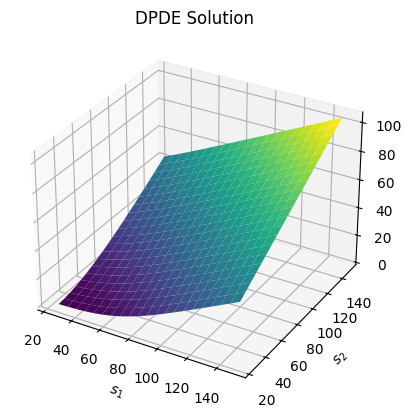

In [251]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, DPDE_solution, cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

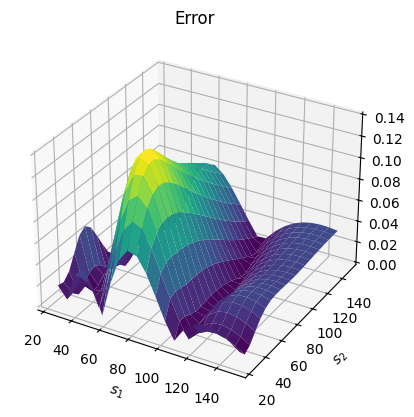

In [252]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(DPDE_solution - exact_solution_evaluated)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

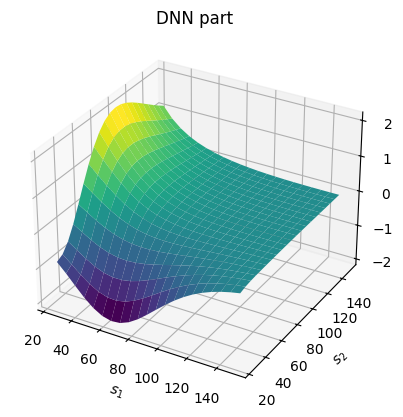

In [253]:
fig = plt.figure()
ax = plt.axes(projection='3d')

dnn_part = DPDE_solution - localisation_plot
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, dnn_part, cmap='viridis')
ax.set_title('DNN part')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

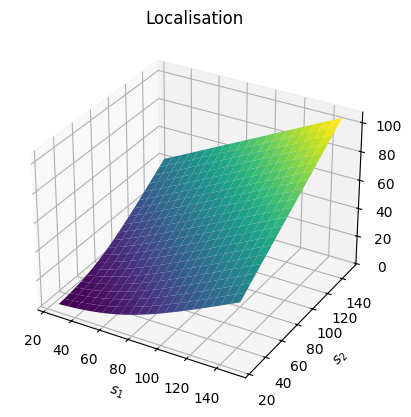

In [254]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, localisation_plot, cmap='viridis')
ax.set_title('Localisation')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

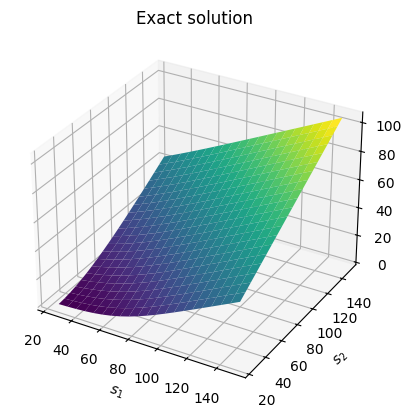

In [255]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, exact_solution_evaluated, cmap='viridis')
ax.set_title('Exact solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

### Scatter plots, varying time, asset prices and parameters

In [256]:
data_samples, t_samples, s1_samples, s2_samples, riskfree_rate_samples, \
  volatility1_samples, volatility2_samples, correlation_samples = \
              get_random_points_of_interest(nr_samples_scatter_plot)

In [257]:
print('Predict {} values and measure the time:'.format(nr_samples_scatter_plot))
%time DPDE_solution = model.predict(data_samples)
# %time DPDE_solution = model.predict(data_samples)['tf_op_layer_AddV2_6'] # if model loaded

Predict 1000 values and measure the time:
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 125 ms
Wall time: 99 ms


In [258]:
exact_solution_evaluated = [exact_solution(t=t, s1=s1, s2=s2,
                                  riskfree_rate=riskfree_rate,
                                  volatility1=volatility1,
                                  volatility2=volatility2,
                                  correlation=correlation
                                  )
                  for t, s1, s2, riskfree_rate, volatility1, volatility2,
                      correlation
                  in zip(t_samples, s1_samples, s2_samples, riskfree_rate_samples,
                          volatility1_samples, volatility2_samples,
                          correlation_samples)]

exact_solution_evaluated = np.array(exact_solution_evaluated).reshape(-1,1)

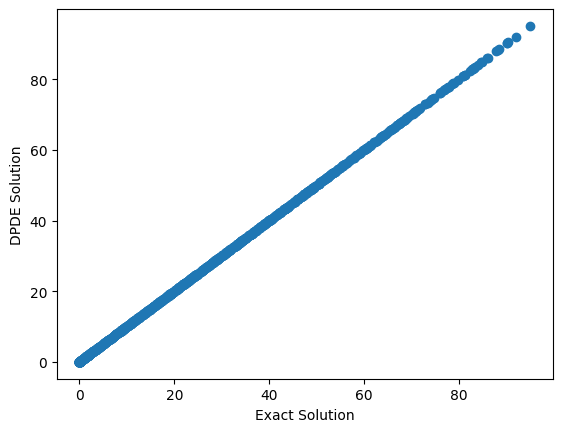

In [259]:
plt.scatter(exact_solution_evaluated, DPDE_solution)
plt.xlabel('Exact Solution')
plt.ylabel('DPDE Solution')
plt.show()

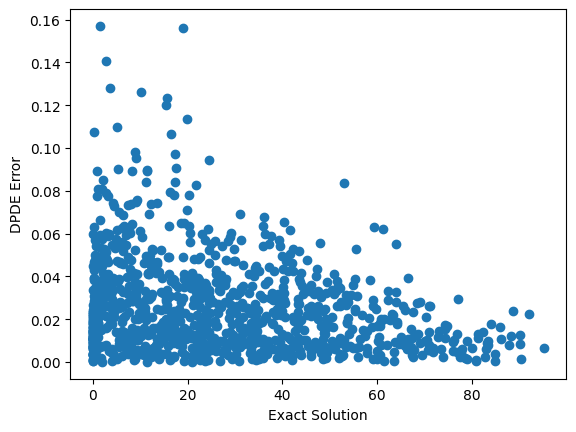

In [260]:
plt.scatter(exact_solution_evaluated,
            np.abs(exact_solution_evaluated - DPDE_solution))
plt.xlabel('Exact Solution')
plt.ylabel('DPDE Error')
plt.show()

### Estimate the error based on random points

In [261]:
data_samples, t_samples, s1_samples, s2_samples, riskfree_rate_samples, \
  volatility1_samples, volatility2_samples, correlation_samples = \
              get_random_points_of_interest(nr_samples_error_calculation)

In [262]:
print('Predict {} values and measure the time:'.format(nr_samples_error_calculation))
%time DPDE_solution = model.predict(data_samples)
# %time DPDE_solution = model.predict(data_samples)['tf_op_layer_AddV2_6'] # if model loaded

Predict 10000 values and measure the time:
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
CPU times: total: 547 ms
Wall time: 359 ms


In [263]:
exact_solution_evaluated = [exact_solution(t=t, s1=s1, s2=s2,
                                  riskfree_rate=riskfree_rate,
                                  volatility1=volatility1,
                                  volatility2=volatility2,
                                  correlation=correlation)
            for t, s1, s2, riskfree_rate, volatility1, volatility2, correlation
            in zip(t_samples, s1_samples, s2_samples, riskfree_rate_samples,
                    volatility1_samples, volatility2_samples,
                    correlation_samples)]

exact_solution_evaluated = np.array(exact_solution_evaluated).reshape(-1, 1)

In [264]:
print('Estimated MSE Error:')
print(np.sqrt(np.mean(np.square(exact_solution_evaluated - DPDE_solution))))

print('Relative Error to L2 Norm in %:')
print(np.sqrt(np.mean(np.square(exact_solution_evaluated - DPDE_solution)))
        / np.sqrt(np.mean(np.square(exact_solution_evaluated)))*100)

print('Maximal Error:')
print(np.max(exact_solution_evaluated - DPDE_solution))

Estimated MSE Error:
0.03276274669152338
Relative Error to L2 Norm in %:
0.09098753847279874
Maximal Error:
0.26433401197528994
